In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from scipy.special import gamma

def data_generator(n, df):
    data = np.abs(np.random.standard_t(df, size=n))
    return (data - mean_theo) / std_theo



def estimator(N, k, O, df):
    # Generate data
    data = data_generator(N, df)
    emp_mean = np.mean(data)

    # Adding outliers
    if O > 0:
        replace_indices = np.random.choice(N, O, replace=False)
        data[replace_indices] = x0

    groups = np.array_split(data, k)
    mu_bar = np.array([np.mean(g) for g in groups])
    sigma_hat = np.array([np.std(g, ddof=1) for g in groups])

    # Calculate mu_MOM
    mu_MOM = np.median([np.mean(g) for g in groups])

    # Calculate mu_hat_N_1
    alpha = (1 / sigma_hat**1) / np.sum(1 / sigma_hat**1)
    mu_hat_N_1 = np.sum(alpha * mu_bar)

    # Calculate mu_hat_N_2
    alpha = (1 / sigma_hat**2) / np.sum(1 / sigma_hat**2)
    mu_hat_N_2 = np.sum(alpha * mu_bar)

    # Calculate mu_Trim
    epsilon = O / N
    trimmed_data = np.sort(data)[
        (np.floor(epsilon * N) + 5).astype(int): -(np.floor(epsilon * N) + 5).astype(int)#epsilon * N=0
    ]
    mu_Trim = np.mean(trimmed_data)

    return mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim, emp_mean


def simulator(N, k_values, O_values, df, simulations, x0):
    results = []
    mu_MOM_print = []
    mu_hat_N_1_print = []
    mu_hat_N_2_print = []
    mu_Trim_print = []
    for O in O_values:
        for k in k_values:
            mu_MOM_errors = []
            mu_hat_N_1_errors = []
            mu_hat_N_2_errors = []
            mu_Trim_errors = []

            for _ in range(simulations):
                #mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim = estimator(N, k, O, df)
                mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim, emp_mean = estimator(N, k, O, df)


                # Calculate errors
                #print(true_mean)
                #true_mean = mean_theo
                true_mean = 0
                #true_mean = emp_mean
                #true_mean = emp_mean - mean_theo
                mu_MOM_errors.append(mu_MOM - true_mean)
                mu_hat_N_1_errors.append(mu_hat_N_1 - true_mean)
                mu_hat_N_2_errors.append(mu_hat_N_2 - true_mean)
                mu_Trim_errors.append(mu_Trim - true_mean)
                mu_MOM_print.append(mu_MOM)
                mu_hat_N_1_print.append(mu_hat_N_1)
                mu_hat_N_2_print.append(mu_hat_N_2)
                mu_Trim_print.append(mu_Trim)

            results.append({
                "O": O,
                "k": k,
                "mu_MOM_avg_error": np.mean(mu_MOM_errors),
                "mu_MOM_std": np.std(mu_MOM_errors),
                "mu_MOM_max_error": np.max(np.abs(mu_MOM_errors)),
                "mu_hat_N_1_avg_error": np.mean(mu_hat_N_1_errors),
                "mu_hat_N_1_std": np.std(mu_hat_N_1_errors),
                "mu_hat_N_1_max_error": np.max(np.abs(mu_hat_N_1_errors)),
                "mu_hat_N_2_avg_error": np.mean(mu_hat_N_2_errors),
                "mu_hat_N_2_std": np.std(mu_hat_N_2_errors),
                "mu_hat_N_2_max_error": np.max(np.abs(mu_hat_N_2_errors)),
                "mu_Trim_avg_error": np.mean(mu_Trim_errors),
                "mu_Trim_std": np.std(mu_Trim_errors),
                "mu_Trim_max_error": np.max(np.abs(mu_Trim_errors)),
            })

    return results, mu_MOM_print, mu_hat_N_1_print, mu_hat_N_2_print, mu_Trim_print

def plot_relative_efficiency(results_dict, N_values, k_values, O_values, simulations):

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    estimators = ["mu_MOM", "mu_hat_N_1", "mu_hat_N_2", "mu_Trim"]
    handles, labels = [], []

    for i, estimator in enumerate(estimators):
        ax = axes[i // 2, i % 2]

        for N in N_values:
            data_set = results_dict[f"{estimator}_print_{N}"]
            re_values = []
            index = 0

            for O in O_values:
                for k in k_values:
                    subset = data_set[index : index + simulations]
                    var = np.var(subset)
                    re = var / var_mu_hat
                    re_values.append(re)
                    index += simulations

            line, = ax.plot(k_values, re_values, marker='o', label=f"N={N}")

            if i == 0:
                handles.append(line)
                labels.append(f"N={N}")

        ax.set_xlabel("k")
        ax.set_ylabel("Relative Efficiency")
        ax.set_title(f"Relative Efficiency of {estimator}")
        ax.grid(True)

    fig.legend(handles=handles, labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(N_values))

    plt.tight_layout()
    plt.show()


def plot_relative_efficiency_bias(results_dict, N_values, k_values, O_values, simulations):

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    estimators = ["mu_MOM", "mu_hat_N_1", "mu_hat_N_2", "mu_Trim"]
    handles, labels = [], []

    for i, estimator in enumerate(estimators):
        ax = axes[i // 2, i % 2]

        for N in N_values:
            data_set = results_dict[f"{estimator}_print_{N}"]
            re_values = []
            index = 0

            for O in O_values:
                for k in k_values:
                    subset = data_set[index : index + simulations]
                    var = np.var(subset)
                    re = (var+np.mean(subset)**2) / (var_mu_hat+mu_hat_bias_sq)
                    re_values.append(re)
                    index += simulations

            line, = ax.plot(k_values, re_values, marker='o', label=f"N={N}")

            if i == 0:
                handles.append(line)
                labels.append(f"N={N}")

        ax.set_xlabel("k")
        ax.set_ylabel("Relative Efficiency")
        ax.set_title(f"Relative Efficiency of {estimator}")
        ax.grid(True)

    fig.legend(handles=handles, labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(N_values))

    plt.tight_layout()
    plt.show()


def plot_relative_efficiency_bias_log(results_dict, N_values, k_values, O_values, simulations):

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    estimators = ["mu_MOM", "mu_hat_N_1", "mu_hat_N_2", "mu_Trim"]
    handles, labels = [], []

    for i, estimator in enumerate(estimators):
        ax = axes[i // 2, i % 2]

        for N in N_values:
            data_set = results_dict[f"{estimator}_print_{N}"]
            re_values = []
            index = 0

            for O in O_values:
                for k in k_values:
                    subset = data_set[index : index + simulations]
                    var = np.var(subset)
                    re = (var+np.mean(subset)**2) / (var_mu_hat+mu_hat_bias_sq)
                    re_values.append(re)
                    index += simulations

            line, = ax.plot(k_values, re_values, marker='o', label=f"N={N}")

            if i == 0:
                handles.append(line)
                labels.append(f"N={N}")

        ax.set_xscale("log")
        ax.set_xlabel("k (log scale)")
        ax.set_ylabel("Relative Efficiency")
        ax.set_title(f"Relative Efficiency of {estimator}")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    fig.legend(handles=handles, labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(N_values))

    plt.tight_layout()
    plt.show()


In [17]:
N_values = [2500, 5000, 7500]
O_values = [0]
k_values = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
df = 4
simulations = 1000
x0 = 10**3
mean_theo = 2 * 1 * np.sqrt(df / np.pi) * (gamma((df + 1) / 2) / (gamma(df / 2) * (df - 1)))
std_theo = np.sqrt(1**2 * (df / (df - 2) - (4 * df) / (np.pi * (df - 1)**2) * (gamma((df + 1) / 2) / gamma(df / 2))**2))
results_dict = {}

for N in N_values:
    results_key = f"results_{N}"
    mu_MOM_key = f"mu_MOM_print_{N}"
    mu_hat_N_1_key = f"mu_hat_N_1_print_{N}"
    mu_hat_N_2_key = f"mu_hat_N_2_print_{N}"
    mu_Trim_key = f"mu_Trim_print_{N}"

    results, mu_MOM_print, mu_hat_N_1_print, mu_hat_N_2_print, mu_Trim_print = simulator(N, k_values, O_values, df, simulations, x0)

    results_dict[results_key] = results
    results_dict[mu_MOM_key] = mu_MOM_print
    results_dict[mu_hat_N_1_key] = mu_hat_N_1_print
    results_dict[mu_hat_N_2_key] = mu_hat_N_2_print
    results_dict[mu_Trim_key] = mu_Trim_print



In [22]:
x_m = 1
alpha_true = 4
mu_MC = []
for _ in range(simulations):
    U = np.random.uniform(0, 1, N)
    samples = x_m * (U ** (-1 / alpha_true))
    alpha_hat = N / np.sum(np.log(samples / x_m))
    if alpha_hat > 1:
        mu_hat = (alpha_hat * x_m) / (alpha_hat - 1)
    else:
        mu_hat = np.nan
    mu_MC.append(mu_hat)
var_mu_hat = np.nanvar(mu_MC)
mu_hat_bias_sq = 0
#mu_hat_bias_sq = np.nanmean(mu_MC) - mean_theo
print("Estimated Var(mu_MLE):", var_mu_hat)


Estimated Var(mu_MLE): 2.616089404537926e-05


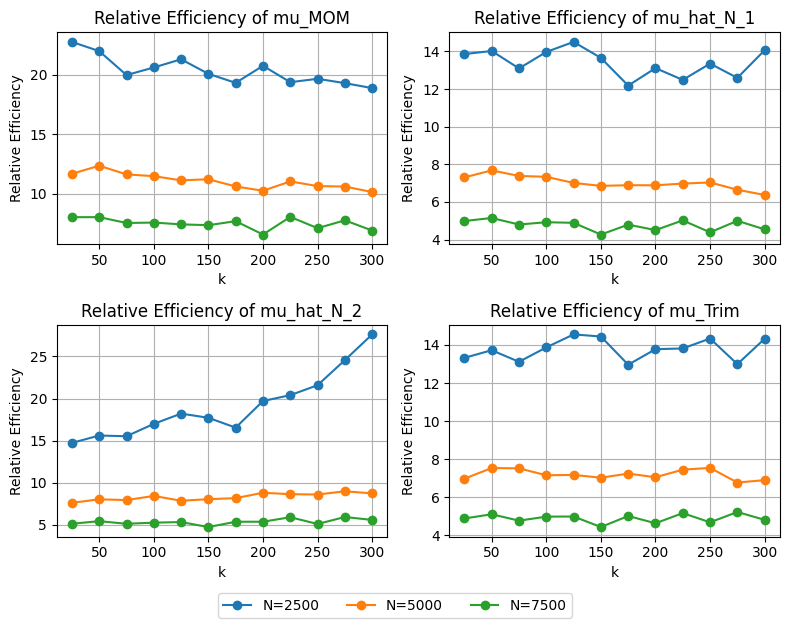

In [31]:
plot_relative_efficiency(results_dict, N_values, k_values, O_values, simulations)


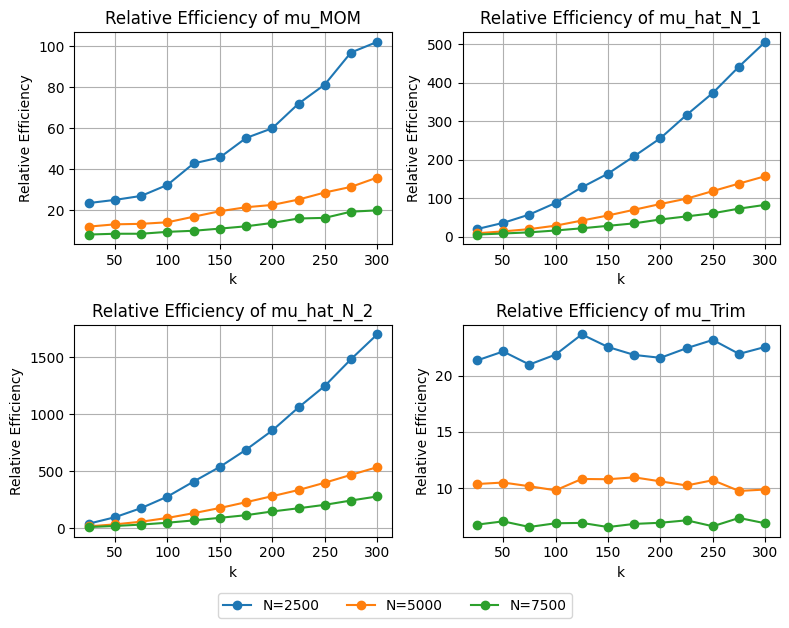

In [32]:
plot_relative_efficiency_bias(results_dict, N_values, k_values, O_values, simulations)

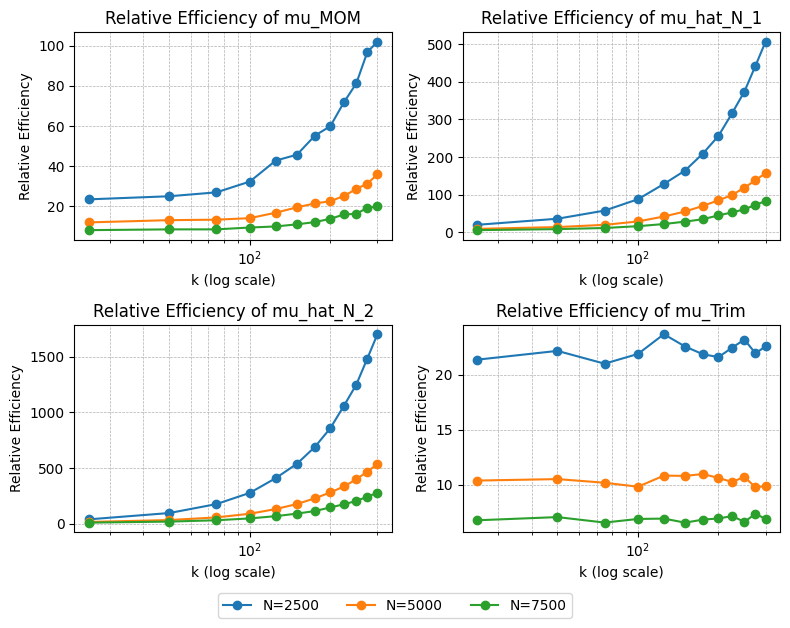

In [33]:
plot_relative_efficiency_bias_log(results_dict, N_values, k_values, O_values, simulations)